<img src="../Archivos/images/python-logo.gif" alt="python" style="width: 700px;"/>

# Interpolación y ajuste

_La últimas tareas importantes que vamos a ver cómo hacer con SciPy van a ser **interpolar** y **ajustar** una serie de puntos. Son tareas diferentes que aprovecharemos en circunstancias distintas, pero ambas muy útiles. Esta clase está basada en el artículo http://pybonacci.org/2013/08/15/ajuste-e-interpolacion-unidimensionales-basicos-en-python-con-scipy/ _

## Dos problemas diferentes

Supongamos que tenemos una serie de puntos que representan los datos de un cierto experimento. Como ejemplo, vamos a cargar los datos de la polar de un avión que están en el archivo `polar.dat`.

In [1]:
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt

In [4]:
#!cat polar.dat  Linux / Mac OS X, !type Windows
!cat ../Archivos/data/polar.dat

# Polar data for a certain airplane
# 1st line: C_L
# 2rd line: C_D

-0.9100  -0.7200  -0.4800  -0.2700  -0.0600   0.1600   0.3100   0.4700   0.6000   0.8200   1.0200   1.2000   1.2400   1.1500   1.0000   0.8000
 0.0538   0.0438   0.0316   0.0245   0.0228   0.0232   0.0262   0.0301   0.0348   0.0461   0.0608   0.0771   0.0814   0.0900   0.0950   0.1000


La primera línea son los datos de $C_L$ y la segunda los datos de $C_D$. Recordamos que había que usar la función `np.loadtxt`, y en este caso no hay que especificar ningún argumento extra más porque ya por defecto detecta que los comentarios empiezan por `#`.

In [5]:
datos = np.loadtxt("../Archivos/data/polar.dat")
C_L = datos[0]
C_D = datos[1]

Vamos a representar esos datos con cruces azules (pista: usar `mew=2`, "marker edge width 2", para que las cruces se vean mejor):

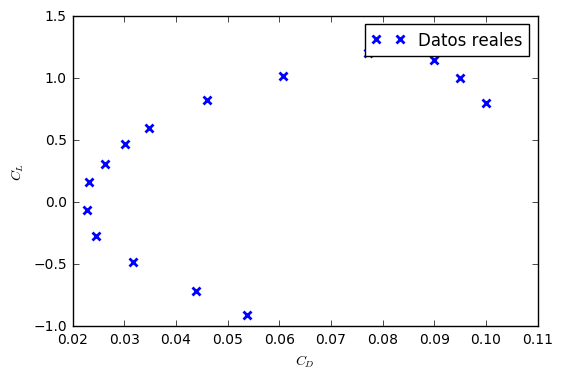

In [6]:
plt.plot(C_D, C_L, 'x', mew=2, label="Datos reales")
plt.xlabel("$C_D$")
plt.ylabel("$C_L$")
plt.legend()

Vemos la forma clásica de la polar de un avión. Hallando *el índice* del máximo valor de $C_L$ podemos descartar los datos fuera de la región de entrada en pérdida, y para eso necesitamos la función `np.argmax`:

In [7]:
idx_stall = np.argmax(C_L)
idx_stall

12

In [8]:
C_L[idx_stall]

1.24

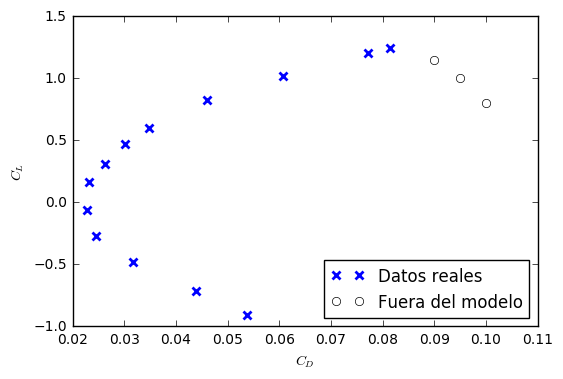

In [9]:
plt.plot(C_D[:idx_stall + 1], C_L[:idx_stall + 1], 'x', mew=2, label="Datos reales")
plt.plot(C_D[idx_stall + 1:], C_L[idx_stall + 1:], 'o', mfc='none', label="Fuera del modelo")
plt.xlabel("$C_D$")
plt.ylabel("$C_L$")
plt.legend(loc=4)

Hay dos cosas que nos pueden interesar:

* Como *solo tenemos puntos intermedios*, no tenemos posibilidad de evaluar, por ejemplo, $C_L$ para un $C_D$ que no esté en los datos. Si **interpolamos** la curva ya podemos hacerlo.
* Sabemos que, fuera de la región de entrada en pérdida, la polar tiene *forma parabólica*. Si **ajustamos** la curva podemos hallar el $C_{D0}$ y el $k$.

## Interpolación

Para interpolar utilizaremos el paquete `interpolate` de SciPy:

In [10]:
from scipy import interpolate

Vamos a generar unos puntos de ejemplo para explicar cómo funciona. Para eso, vamos a usar simplemente la función $\sin{x}$ en un dominio con pocos puntos:

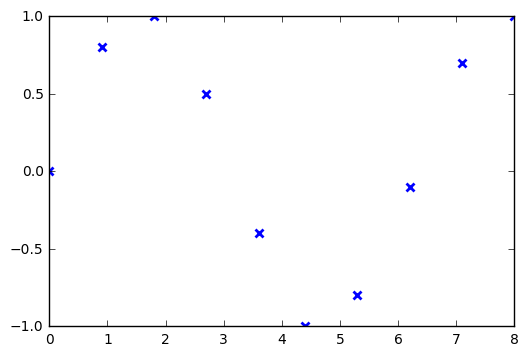

In [11]:
x_i = [0.0, 0.9, 1.8, 2.7, 3.6, 4.4, 5.3, 6.2, 7.1, 8.0]
y_i = [0.0, 0.8, 1.0, 0.5, -0.4, -1.0, -0.8, -0.1, 0.7, 1.0]
plt.plot(x_i, y_i, 'x', mew=2)

Para crear una **función interpolante** utilizaremos el objeto `InterpolatedUnivariateSpline` del paquete `interpolate`. A este objeto solo hay que pasarle los puntos de interpolación y el grado, y generará un *spline*.

In [12]:
f_interp = interpolate.InterpolatedUnivariateSpline(x_i, y_i, k=1)
f_interp

¿Cómo obtengo los puntos desde aquí? El resultado que hemos obtenido es una *función* y admite como argumento la $x$.

In [13]:
f_interp(np.pi / 2)

array(0.949065850398866)

Vamos a representar esta función junto con los puntos de interpolación. Fíjate en que, ahora que tenemos una función interpolante, podemos representarla en un dominio:

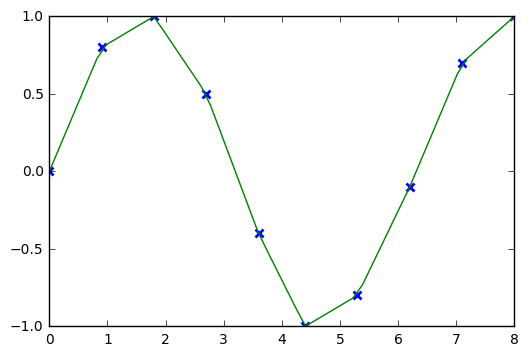

In [14]:
x = np.linspace(0, 8)
y_interp = f_interp(x)

plt.plot(x_i, y_i, 'x', mew=2)
plt.plot(x, y_interp)

Retrocede ahora y comprueba lo que pasa si cambias el grado del *spline*.

**Ejercicio**: Crear una función interpolante $C_D = f(C_L)$ usando splines de grado 2 y representarla. Utiliza solo los datos que resultan de haber eliminado la región de entrada en pérdida. y ten en cuenta que la $x$ y la $y$ para este caso están cambiadas de sitio.

1. Crea un polinomio interpolante usando los valores que encajan en el modelo parabólico.
2. Crea un dominio de $C_L$ entre `C_L.min()` y `C_L.max()`.
3. Halla los valores interpolados de $C_D$ en ese dominio.
4. Representa la función y los puntos.

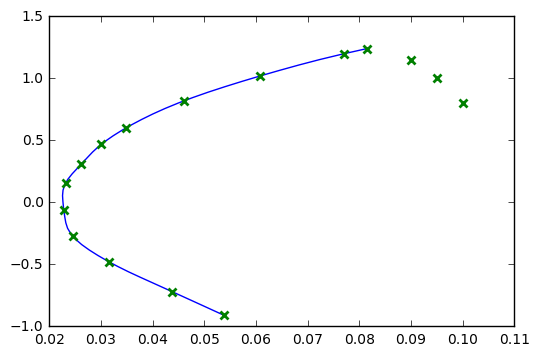

In [15]:
f_C_D = interpolate.InterpolatedUnivariateSpline(C_L[:idx_stall + 1], C_D[:idx_stall + 1], k=2)

C_L_domain = np.linspace(C_L.min(), C_L.max())
C_D_interp = f_C_D(C_L_domain)

plt.plot(C_D_interp, C_L_domain)
plt.plot(C_D, C_L, 'x', mew=2)

## Ajuste

El ajuste funciona de manera totalmente distinta: obtendremos una curva que no pasará por ninguno de los puntos originales, pero que a cambio tendrá una expresión analítica simple. Para realizar ajustes polinómicos vamos a utilizar el paquete `np.polynomial.polynomial` (sí, está dos veces).

In [16]:
from numpy.polynomial import polynomial

Vamos otra vez a generar unos datos para ver cómo funcionaría, del tipo:

$$y(x) = x^2 - x + 1 + \text{Ruido}$$

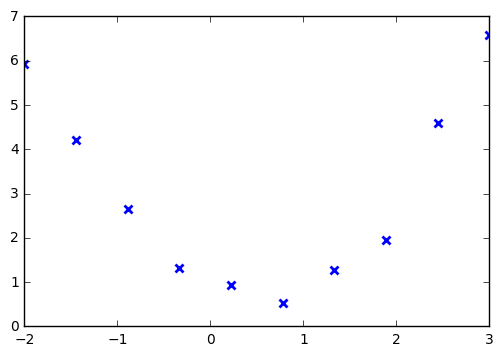

In [17]:
x_i = np.linspace(-2, 3, num=10)
y_i = x_i ** 2 - x_i + 1 + 0.5 * np.random.randn(10)
plt.plot(x_i, y_i, 'x', mew=2)

Vamos a utilizar la función `polynomial.polyfit`, que recibe los puntos de interpolación y el grado del polinomio. El resultado serán los coeficientes del mismo, **en orden de potencias crecientes**.

In [18]:
a, b, c = polynomial.polyfit(x_i, y_i, deg=2)
a, b, c

(0.87638672325925704, -0.86373288073332422, 0.91216904857871561)

¡Muy similares a lo que esperábamos! Para evaluar un polinomio con estos coeficientes, o bien construimos la función nosotros mismos o usamos la función `polynomial.polyval`:

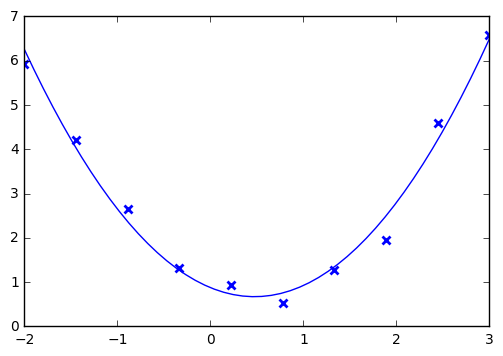

In [19]:
x = np.linspace(-2, 3)
#y_fit = a + b * x + c * x ** 2
y_fit = polynomial.polyval(x, (a, b, c))

l, = plt.plot(x, y_fit)
plt.plot(x_i, y_i, 'x', mew=2, c=l.get_color())

**Ejercicio**: Si modelizamos la polar como:

$$C_D = C_{D0} + k C_L^2$$

hallar los coeficientes $C_{D0}$ y $k$.

<p></p>

<div class="alert alert-warning">**¡Importante!** Estamos tentados de hacer un ajuste parabólico pero ese no es el camino, porque nos dará un término lineal que ya sabemos que es cero. Es mejor hacer un cambio de variable y hacer un ajuste lineal:</div>

$$y \leftarrow C_D \\ x \leftarrow C_L^2 \\ y = C_{D0} + k x$$

In [20]:
y_i = C_D[:idx_stall + 1]
x_i = C_L[:idx_stall + 1] ** 2

C_D0, k = polynomial.polyfit(x_i, y_i, deg=1)
C_D0, k

(0.022155579233867954, 0.038058791717716367)

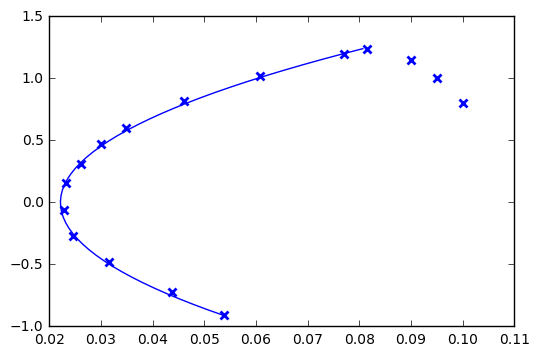

In [21]:
#C_D_fit = polynomial.polyval(C_L_domain ** 2, (C_D0, k))
C_D_fit = C_D0 + k * C_L_domain ** 2

l, = plt.plot(C_D_fit, C_L_domain)
plt.plot(C_D, C_L, 'x', mew=2, c=l.get_color())

In [ ]:
### *[DARLE AQUI PARA SEGUIR !!](/notebooks/Modulo 2/014-SciPy-EcuacionesNoLineales.ipynb)*

##### <script src="//platform.linkedin.com/in.js" type="text/javascript"></script> <script type="IN/MemberProfile" data-id="http://es.linkedin.com/in/juanluiscanor" data-format="inline" data-related="false"></script> <script src="//platform.linkedin.com/in.js" type="text/javascript"></script> <script type="IN/MemberProfile" data-id="http://es.linkedin.com/in/alejandrosaezm" data-format="inline" data-related="false"></script>

In [1]:
# Esta celda da el estilo al notebook
from IPython.core.display import HTML
css_file = '../Archivos/styles/aeropython.css'
HTML(open(css_file, "r").read())